In [21]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Settings to produce nice plots in a Jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns

# To extract and parse fundamental data from finviz website
import requests
from bs4 import BeautifulSoup as bs

# For parsing financial statements data from financialmodelingprep api
from urllib.request import urlopen
import json
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Financialmodelingprep api url
base_url = "https://financialmodelingprep.com/api/v3/"

In [59]:
apiKey = "your own apikey"
ticker = "AAPL"

In [60]:
q_cash_flow_statement = pd.DataFrame(get_jsonparsed_data(base_url+'cash-flow-statement/' + ticker + '?period=quarter' + '&apikey=' + apiKey))
q_cash_flow_statement = q_cash_flow_statement.set_index('date').iloc[:4] # extract for last 4 quarters
q_cash_flow_statement = q_cash_flow_statement.apply(pd.to_numeric, errors='coerce')

q_cash_flow_statement.iloc[:,4:].head()

,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivities,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-26,NaN,2.174400e+10,2.832000e+09,-530000000.0,1.960000e+09,-4.697000e+09,1.031000e+09,13000000.0,2.110000e+08,9.600000e+07,-215000000.0,2.109400e+10,-2.093000e+09,-4000000.0,-1.962800e+10,2.537500e+10,-78000000.0,3.572000e+09,-3.000000e+09,0.0,-2.290000e+10,-3.767000e+09,2.710000e+08,-2.939600e+10,0.0,-4.730000e+09,3.527600e+10,4.000600e+10,2.109400e+10,-2.093000e+09,1.900100e+10,NaN,NaN
2021-03-27,NaN,2.363000e+10,2.797000e+09,-149000000.0,1.981000e+09,-3.779000e+09,8.598000e+09,-276000000.0,-2.366700e+10,3.010000e+08,-499000000.0,2.398100e+10,-2.269000e+09,0.0,-3.462400e+10,2.672900e+10,-204000000.0,-1.036800e+10,-3.500000e+09,561000000.0,-1.854800e+10,-3.447000e+09,1.360800e+10,-1.132600e+10,0.0,2.287000e+09,4.000600e+10,3.771900e+10,2.398100e+10,-2.269000e+09,2.171200e+10,NaN,NaN
2020-12-26,NaN,2.875500e+10,2.666000e+09,-58000000.0,2.020000e+09,5.355000e+09,-1.094500e+10,-950000000.0,2.167000e+10,1.341000e+09,25000000.0,3.876300e+10,-3.500000e+09,-9000000.0,-3.980000e+10,3.452100e+10,204000000.0,-8.584000e+09,-1.000000e+09,0.0,-2.477500e+10,-3.613000e+09,-2.861000e+09,-3.224900e+10,0.0,-2.070000e+09,3.771900e+10,3.978900e+10,3.876300e+10,-3.500000e+09,3.526300e+10,NaN,NaN
2020-09-26,NaN,1.267300e+10,2.702000e+09,-397000000.0,1.724000e+09,3.877000e+09,1.768000e+09,-137000000.0,6.725000e+09,4.320000e+08,-3000000.0,2.057600e+10,-1.784000e+09,-51000000.0,-1.833200e+10,2.580000e+10,-102000000.0,5.531000e+09,0.000000e+00,450000000.0,-1.718700e+10,-3.511000e+09,-1.109000e+09,-2.135700e+10,0.0,4.750000e+09,3.978900e+10,3.503900e+10,2.057600e+10,-1.784000e+09,1.879200e+10,NaN,NaN


In [62]:
cash_flow_statement = pd.DataFrame(get_jsonparsed_data(base_url+'cash-flow-statement/' + ticker + '?apikey=' + apiKey))
cash_flow_statement = cash_flow_statement.set_index('date')
cash_flow_statement = cash_flow_statement.apply(pd.to_numeric, errors='coerce')
    
cash_flow_statement.iloc[:,4:].head()

,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivities,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-26,NaN,57411000000,11056000000,-2.150000e+08,6.829000e+09,5690000000,6.917000e+09,-127000000,-4.062000e+09,2.081000e+09,-9.700000e+07,80674000000,-7309000000,-1.524000e+09,-1.151480e+11,1.204830e+11,-7.910000e+08,-4.289000e+09,-1.262900e+10,880000000.0,-72358000000,-1.408100e+10,1.136800e+10,-86820000000,0.0,-1.043500e+10,3.978900e+10,50224000000,80674000000,-7309000000,73365000000,NaN,NaN
2019-09-28,NaN,55256000000,12547000000,-3.400000e+08,6.068000e+09,-3488000000,2.450000e+08,-289000000,-1.923000e+09,-6.250000e+08,-6.520000e+08,69391000000,-10495000000,-6.240000e+08,-4.063100e+10,9.872400e+10,-1.078000e+09,4.589600e+10,-8.805000e+09,781000000.0,-66897000000,-1.411900e+10,-1.936000e+09,-90976000000,0.0,2.431100e+10,5.022400e+10,25913000000,69391000000,-10495000000,58896000000,NaN,NaN
2018-09-29,NaN,59531000000,10903000000,-3.259000e+10,5.340000e+09,34694000000,-5.322000e+09,828000000,9.175000e+09,-4.400000e+07,-4.440000e+08,77434000000,-13313000000,-7.210000e+08,-7.322700e+10,1.040720e+11,-7.450000e+08,1.606600e+10,-6.500000e+09,669000000.0,-72738000000,-1.371200e+10,4.405000e+09,-87876000000,0.0,5.624000e+09,2.591300e+10,20289000000,77434000000,-13313000000,64121000000,NaN,NaN
2017-09-30,NaN,48351000000,10157000000,5.966000e+09,4.840000e+09,-5550000000,-2.093000e+09,-2723000000,9.618000e+09,-6.260000e+08,-1.660000e+08,63598000000,-12451000000,-3.290000e+08,-1.598810e+11,1.263390e+11,-1.240000e+08,-4.644600e+10,-3.500000e+09,555000000.0,-32900000000,-1.276900e+10,3.126700e+10,-17347000000,0.0,-1.950000e+08,2.028900e+10,20484000000,63598000000,-12795000000,50803000000,NaN,NaN
2016-09-24,NaN,45687000000,10505000000,4.938000e+09,4.210000e+09,484000000,1.095000e+09,217000000,1.791000e+09,-1.554000e+09,4.696000e+09,66231000000,-12734000000,-2.970000e+08,-3.111000e+10,2.125800e+10,-2.309400e+10,-4.597700e+10,-2.500000e+09,495000000.0,-29227000000,-1.215000e+10,2.249200e+10,-20890000000,0.0,-6.360000e+08,2.048400e+10,21120000000,66231000000,-12734000000,53497000000,NaN,NaN


In [63]:
ttm_cash_flow_statement = q_cash_flow_statement.sum() # sum up last 4 quarters to get TTM cash flow
cash_flow_statement = cash_flow_statement[::-1].append(ttm_cash_flow_statement.rename('TTM')).drop(['netIncome'], axis=1)
final_cash_flow_statement = cash_flow_statement[::-1] # reverse list to show most recent ones first
final_cash_flow_statement.iloc[:,4:].head()

,period,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivities,investmentsInPropertyPlantAndEquipment,acquisitionsNet,purchasesOfInvestments,salesMaturitiesOfInvestments,otherInvestingActivites,netCashUsedForInvestingActivites,debtRepayment,commonStockIssued,commonStockRepurchased,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TTM,0.0,1.099700e+10,-1.134000e+09,7.685000e+09,7.560000e+08,4.520000e+08,-1.350000e+09,4.939000e+09,2.170000e+09,-692000000.0,1.044140e+11,-9.646000e+09,-6.400000e+07,-1.123840e+11,1.124250e+11,-1.800000e+08,-9.849000e+09,-7.500000e+09,1.011000e+09,-8.341000e+10,-1.433800e+10,9.909000e+09,-9.432800e+10,0.0,2.370000e+08,1.527900e+11,1.525530e+11,1.044140e+11,-9.646000e+09,9.476800e+10,0.0,0.0
2020-09-26,NaN,1.105600e+10,-2.150000e+08,6.829000e+09,5.690000e+09,6.917000e+09,-1.270000e+08,-4.062000e+09,2.081000e+09,-97000000.0,8.067400e+10,-7.309000e+09,-1.524000e+09,-1.151480e+11,1.204830e+11,-7.910000e+08,-4.289000e+09,-1.262900e+10,8.800000e+08,-7.235800e+10,-1.408100e+10,1.136800e+10,-8.682000e+10,0.0,-1.043500e+10,3.978900e+10,5.022400e+10,8.067400e+10,-7.309000e+09,7.336500e+10,NaN,NaN
2019-09-28,NaN,1.254700e+10,-3.400000e+08,6.068000e+09,-3.488000e+09,2.450000e+08,-2.890000e+08,-1.923000e+09,-6.250000e+08,-652000000.0,6.939100e+10,-1.049500e+10,-6.240000e+08,-4.063100e+10,9.872400e+10,-1.078000e+09,4.589600e+10,-8.805000e+09,7.810000e+08,-6.689700e+10,-1.411900e+10,-1.936000e+09,-9.097600e+10,0.0,2.431100e+10,5.022400e+10,2.591300e+10,6.939100e+10,-1.049500e+10,5.889600e+10,NaN,NaN
2018-09-29,NaN,1.090300e+10,-3.259000e+10,5.340000e+09,3.469400e+10,-5.322000e+09,8.280000e+08,9.175000e+09,-4.400000e+07,-444000000.0,7.743400e+10,-1.331300e+10,-7.210000e+08,-7.322700e+10,1.040720e+11,-7.450000e+08,1.606600e+10,-6.500000e+09,6.690000e+08,-7.273800e+10,-1.371200e+10,4.405000e+09,-8.787600e+10,0.0,5.624000e+09,2.591300e+10,2.028900e+10,7.743400e+10,-1.331300e+10,6.412100e+10,NaN,NaN
2017-09-30,NaN,1.015700e+10,5.966000e+09,4.840000e+09,-5.550000e+09,-2.093000e+09,-2.723000e+09,9.618000e+09,-6.260000e+08,-166000000.0,6.359800e+10,-1.245100e+10,-3.290000e+08,-1.598810e+11,1.263390e+11,-1.240000e+08,-4.644600e+10,-3.500000e+09,5.550000e+08,-3.290000e+10,-1.276900e+10,3.126700e+10,-1.734700e+10,0.0,-1.950000e+08,2.028900e+10,2.048400e+10,6.359800e+10,-1.279500e+10,5.080300e+10,NaN,NaN


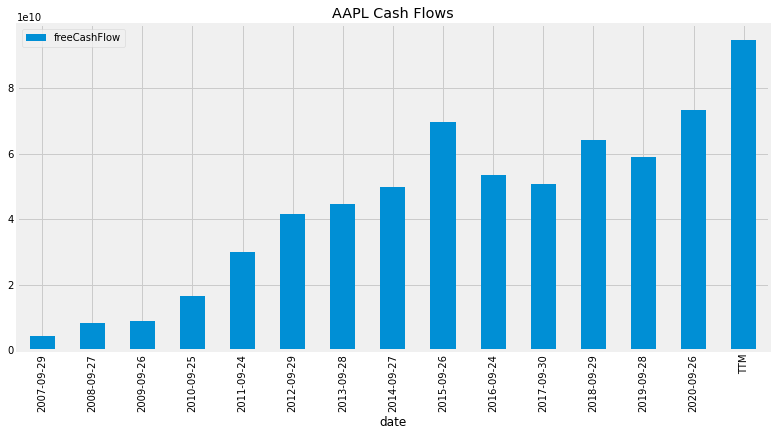

In [64]:
final_cash_flow_statement[['freeCashFlow']].iloc[::-1].iloc[-15:].plot(kind='bar', title=ticker + ' Cash Flows')
plt.show()

In [65]:
q_balance_statement = pd.DataFrame(get_jsonparsed_data(base_url+'balance-sheet-statement/' + ticker + '?period=quarter' + '&apikey=' + apiKey))
q_balance_statement = q_balance_statement.set_index('date')
q_balance_statement = q_balance_statement.apply(pd.to_numeric, errors='coerce')
q_balance_statement.iloc[:,4:].head()

,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,goodwillAndIntangibleAssets,longTermInvestments,taxAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,totalAssets,accountPayables,shortTermDebt,taxPayables,deferredRevenue,otherCurrentLiabilities,totalCurrentLiabilities,longTermDebt,deferredRevenueNonCurrent,deferredTaxLiabilitiesNonCurrent,otherNonCurrentLiabilities,totalNonCurrentLiabilities,otherLiabilities,totalLiabilities,commonStock,retainedEarnings,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalLiabilitiesAndStockholdersEquity,totalInvestments,totalDebt,netDebt,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-26,NaN,34050000000,2.764600e+10,61696000000,33908000000,5.178000e+09,13641000000,114423000000,38615000000,0.0,0.0,0.0,1.319480e+11,0.0,4.485400e+10,215417000000,0.000000e+00,329840000000,4.040900e+10,1.603900e+10,0.0,7.681000e+09,43625000000,107754000000,1.057520e+11,0.0,0.0,5.205400e+10,157806000000,0.0,265560000000,5.498900e+10,9233000000,58000000.0,0.0,64280000000,329840000000,1.595940e+11,1.217910e+11,8.774100e+10,NaN,NaN
2021-03-27,NaN,38466000000,3.136800e+10,69834000000,33036000000,5.219000e+09,13376000000,121465000000,37815000000,0.0,0.0,0.0,1.345390e+11,0.0,4.333900e+10,215693000000,0.000000e+00,337158000000,4.012700e+10,1.300300e+10,0.0,7.595000e+09,45660000000,106385000000,1.086420e+11,0.0,0.0,5.295300e+10,161595000000,0.0,267980000000,5.420300e+10,15261000000,-286000000.0,0.0,69178000000,337158000000,1.659070e+11,1.216450e+11,8.317900e+10,NaN,NaN
2020-12-26,NaN,36010000000,4.081600e+10,76826000000,58620000000,4.973000e+09,13687000000,154106000000,37933000000,0.0,0.0,0.0,1.187450e+11,0.0,4.327000e+10,199948000000,0.000000e+00,354054000000,6.384600e+10,1.276200e+10,0.0,7.395000e+09,48504000000,132507000000,9.928100e+10,0.0,0.0,5.604200e+10,155323000000,0.0,287830000000,5.174400e+10,14301000000,179000000.0,0.0,66224000000,354054000000,1.595610e+11,1.120430e+11,7.603300e+10,NaN,NaN
2020-09-26,NaN,38016000000,5.292700e+10,90943000000,37445000000,4.061000e+09,11264000000,143713000000,36766000000,0.0,0.0,0.0,1.008870e+11,0.0,4.252200e+10,180175000000,9.048200e+10,323888000000,4.229600e+10,1.376900e+10,0.0,6.643000e+09,42684000000,105392000000,9.866700e+10,0.0,0.0,5.449000e+10,153157000000,0.0,258549000000,5.077900e+10,14966000000,-406000000.0,0.0,65339000000,323888000000,1.538140e+11,1.124360e+11,7.442000e+10,NaN,NaN
2020-06-27,NaN,33383000000,5.964200e+10,93025000000,32075000000,3.978000e+09,10987000000,140065000000,35687000000,0.0,0.0,0.0,1.005920e+11,0.0,4.100000e+10,177279000000,0.000000e+00,317344000000,3.532500e+10,1.867500e+10,0.0,6.313000e+09,35005000000,95318000000,9.404800e+10,0.0,0.0,5.569600e+10,149744000000,0.0,245062000000,4.869600e+10,24136000000,-550000000.0,0.0,72282000000,317344000000,1.602340e+11,1.127230e+11,7.934000e+10,NaN,NaN


In [66]:
cash_flow = final_cash_flow_statement.iloc[0]['freeCashFlow']
total_debt = q_balance_statement.iloc[0]['totalDebt'] 
cash_and_ST_investments = q_balance_statement.iloc[0]['cashAndShortTermInvestments']

print("Free Cash Flow: ", cash_flow)
print("Total Debt: ", total_debt)
print("Cash and ST Investments: ", cash_and_ST_investments)

Free Cash Flow:  94768000000.0
Total Debt:  121791000000.0
Cash and ST Investments:  61696000000.0


In [67]:
# List of data we want to extract from Finviz Table
metric = ['Price', 'EPS next 5Y', 'Beta', 'Shs Outstand']

def fundamental_metric(soup, metric):
    # the table which stores the data in Finviz has html table attribute class of 'snapshot-td2'
    return soup.find(text = metric).find_next(class_='snapshot-td2').text
   
def get_finviz_data(ticker):
    try:
        url = ("http://finviz.com/quote.ashx?t=" + ticker.lower())
        soup = bs(requests.get(url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}).content)
        dict_finviz = {}        
        for m in metric:   
            dict_finviz[m] = fundamental_metric(soup,m)
        for key, value in dict_finviz.items():
            # replace percentages
            if (value[-1]=='%'):
                dict_finviz[key] = value[:-1]
                dict_finviz[key] = float(dict_finviz[key])
            # billion
            if (value[-1]=='B'):
                dict_finviz[key] = value[:-1]
                dict_finviz[key] = float(dict_finviz[key])*1000000000  
            # million
            if (value[-1]=='M'):
                dict_finviz[key] = value[:-1]
                dict_finviz[key] = float(dict_finviz[key])*1000000
            try:
                dict_finviz[key] = float(dict_finviz[key])
            except:
                pass 
    except Exception as e:
        print (e)
        print ('Not successful parsing ' + ticker + ' data.')        
    return dict_finviz

finviz_data = get_finviz_data(ticker)

finviz_data

{'Beta': 1.22,
 'EPS next 5Y': 19.86,
 'Price': 139.68,
 'Shs Outstand': 16629999999.999998}

In [68]:
 Beta = finviz_data['Beta']

discount_rate = 7
if(Beta<0.80):
    discount_rate = 5
elif(Beta>=0.80 and Beta<1):
    discount_rate = 6
elif(Beta>=1 and Beta<1.1):
    discount_rate = 6.5
elif(Beta>=1.1 and Beta<1.2):
    discount_rate = 7
elif(Beta>=1.2 and Beta<1.3):
    discount_rate =7.5
elif(Beta>=1.3 and Beta<1.4):
    discount_rate = 8
elif(Beta>=1.4 and Beta<1.6):
    discount_rate = 8.5
elif(Beta>=1.61):
    discount_rate = 9   

print("Discount Rate: ", discount_rate)

Discount Rate:  7.5


In [69]:
EPS_growth_5Y = finviz_data['EPS next 5Y']
EPS_growth_6Y_to_10Y = EPS_growth_5Y/2  # Half the previous growth rate, conservative estimate
EPS_growth_11Y_to_20Y  = np.minimum(EPS_growth_6Y_to_10Y, 4)  # Slightly higher than long term inflation rate, conservative estimate

shares_outstanding = finviz_data['Shs Outstand']

print("Free Cash Flow: ", cash_flow)
print("Total Debt: ", total_debt)
print("Cash and ST Investments: ", cash_and_ST_investments)

print("EPS Growth 5Y: ", EPS_growth_5Y)
print("EPS Growth 6Y to 10Y: ", EPS_growth_6Y_to_10Y)
print("EPS Growth 11Y to 20Y: ", EPS_growth_11Y_to_20Y)

print("Discount Rate: ", discount_rate)

print("Shares Outstanding: ", shares_outstanding)

Free Cash Flow:  94768000000.0
Total Debt:  121791000000.0
Cash and ST Investments:  61696000000.0
EPS Growth 5Y:  19.86
EPS Growth 6Y to 10Y:  9.93
EPS Growth 11Y to 20Y:  4.0
Discount Rate:  7.5
Shares Outstanding:  16629999999.999998


Discounted Cash Flows

Year 1: $105664116093.02324
Year 2: $117813032138.6955
Year 3: $131358790996.68877
Year 4: $146461997105.70337
Year 5: $163301720679.90332
Year 6: $166993099110.156
Year 7: $170767919862.1344
Year 8: $174628069120.41333
Year 9: $178575475706.112
Year 10: $182612112040.67804
Year 11: $176666601416.0978
Year 12: $170914665556.03885
Year 13: $165350002026.30737
Year 14: $159966513588.24158
Year 15: $154758301517.92673
Year 16: $149719659142.92447
Year 17: $144845065589.4339
Year 18: $140129179733.03375
Year 19: $135566834346.37685
Year 20: $131153030437.42503


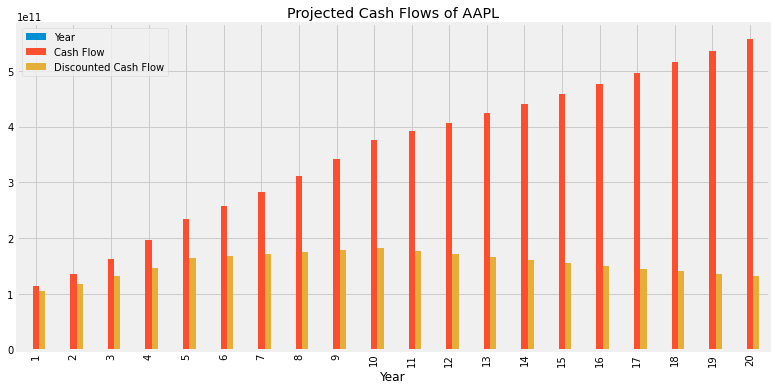

In [70]:
def calculate_intrinsic_value(cash_flow, total_debt, cash_and_ST_investments, 
                                  EPS_growth_5Y, EPS_growth_6Y_to_10Y, EPS_growth_11Y_to_20Y,
                                  shares_outstanding, discount_rate):   
    
    # Convert all percentages to decmials
    EPS_growth_5Y_d = EPS_growth_5Y/100
    EPS_growth_6Y_to_10Y_d = EPS_growth_6Y_to_10Y/100
    EPS_growth_11Y_to_20Y_d = EPS_growth_11Y_to_20Y/100
    discount_rate_d = discount_rate/100
    print("Discounted Cash Flows\n")
    
    # Lists of projected cash flows from year 1 to year 20
    cash_flow_list = []
    cash_flow_discounted_list = []
    year_list = []
    
    
    # Years 1 to 5
    for year in range(1, 6):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_5Y_d)        
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
        print("Year " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    # Years 6 to 10
    for year in range(6, 11):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_6Y_to_10Y_d)
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
        print("Year " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    # Years 11 to 20
    for year in range(11, 21):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_11Y_to_20Y_d)
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
        print("Year " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    intrinsic_value = (sum(cash_flow_discounted_list) - total_debt + cash_and_ST_investments)/shares_outstanding
    df = pd.DataFrame.from_dict({'Year': year_list, 'Cash Flow': cash_flow_list, 'Discounted Cash Flow': cash_flow_discounted_list})
    df.index = df.Year
    df.plot(kind='bar', title = 'Projected Cash Flows of ' + ticker)
    plt.show()

    return intrinsic_value


intrinsic_value = calculate_intrinsic_value(cash_flow, total_debt, cash_and_ST_investments, 
                                  EPS_growth_5Y, EPS_growth_6Y_to_10Y, EPS_growth_11Y_to_20Y,
                                  shares_outstanding, discount_rate)    


In [71]:
print("Intrinsic Value: ", intrinsic_value)
current_price = finviz_data['Price']
print("Current Price: ", current_price)
print("Margin of Safety: ", (1-current_price/intrinsic_value)*100) 

Intrinsic Value:  180.82689033116742
Current Price:  139.68
Margin of Safety:  22.75485148022551
